# SkyModel (KOALA tutorial)

This tutorial demonstrates several ways to estimate and subtract night–sky emission
using **pyKOALA** on *KOALA* RSS data. We will:
- build a `SkyFromObject` model;
- explore alternative background estimators;
- run PCA-based residual sky subtraction; and
- generate quick diagnostic plots.


# 1. Initialisation

## Imports

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
import numpy as np


In [2]:
from pykoala import __version__
from pykoala.instruments import koala_ifu
from pykoala.corrections import sky
print("pyKOALA version:", __version__)


pyKOALA version: 0.18.3+106.g12c1118.dirty


In [3]:
# Optional extras (uncomment as needed)
'''
from astropy import units as u
from pykoala.plotting.utils import new_figure, plot_image, plot_fibres
from matplotlib.colors import LogNorm, Normalize
import scipy
from pykoala.ancillary import symmetric_background
'''


'\nfrom astropy import units as u\nfrom pykoala.plotting.utils import new_figure, plot_image, plot_fibres\nfrom matplotlib.colors import LogNorm, Normalize\nimport scipy\nfrom pykoala.ancillary import symmetric_background\n'

In [4]:
%load_ext autoreload
%autoreload 2


## Load the science data

This notebook expects a **KOALA** Row-Stacked Spectra (RSS) FITS file.
Update the path below to your local copy if needed.


In [5]:
# Path to a KOALA RSS file (example)
filename = "../data/koala/385R/27feb20036red.fits"

# Read RSS
rss0 = koala_ifu.koala_rss(filename)


[pykoala] 2025/10/05 21:08|INFO> 
> Reading KOALA RSS file 27feb20036red.fits
[pykoala] 2025/10/05 21:08|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/10/05 21:08|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]


  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]


### Data summary

In [6]:
print(f"Analysing object {rss0.info['name']} read from {filename}")
print("- info keys:")
print(list(rss0.info.keys()))
print("- history:")
rss0.history.show()


Analysing object He2-10 F 1.5E 1.5S read from ../data/koala/385R/27feb20036red.fits
- info keys:
['name', 'exptime', 'fib_ra', 'fib_dec', 'airmass']
- history:
read: - RSS read from  27feb20036red.fits


# 2. SkyFromObject

In [7]:
print(sky.SkyFromObject.__doc__)


Derive a sky model from a single `DataContainer` containing object + sky.

The class estimates the sky background by selecting sky-dominated fibres
and applying a robust background estimator, with optional continuum removal.

Attributes
----------
dc : DataContainer
    Input container the model was derived from.
bckgr : ndarray or None
    Estimated background (returned by the estimator).
bckgr_sigma : ndarray or None
    Estimated background standard deviation.
continuum : ndarray or None
    Estimated continuum of the sky model.



In [8]:
help(sky.SkyFromObject.__init__)

Help on function __init__ in module pykoala.corrections.sky:

__init__(
    self,
    dc,
    bckgr_estimator='mad',
    bckgr_params=None,
    sky_fibres=None,
    source_mask_kappa_sigma=None,
    remove_cont=False,
    cont_estimator='median',
    cont_estimator_args=None,
    qc_plots={'show': True},
    **kwargs
)
    Initialise the model from a `DataContainer`.

    Parameters
    ----------
    dc : DataContainer
        Input data container.
    bckgr_estimator : str, optional
        Name of the background estimator to use (e.g., ``'mad'``). Default 'mad'.
    bckgr_params : dict, optional
        Keyword arguments passed to the background estimator. Default None.
    sky_fibres : {'auto', 'all'} or sequence of int, optional
        Strategy or explicit indices for sky-fibre selection. If None, use the
        list from ``dc.sky_fibres`` or fall back to ``'auto'``. Default None.
    source_mask_kappa_sigma : float, optional
        Sigma threshold for masking bright source con

## Default procedure

In [9]:
# Toggle to run the extra comparisons and show QC figures inline
test_alternative_methods = True

def show_if(condition, fig):
    return fig if condition else None

# Build a sky model using the default workflow
sky_model = sky.SkyFromObject(rss0, qc_plots={'show': not test_alternative_methods})


[pykoala.SkyModel] 2025/10/05 21:08|INFO> Creating SkyModel from input Data Container
[pykoala.SkyModel] 2025/10/05 21:08|INFO> Automatic sky fibre selection
[pykoala.SkyModel] 2025/10/05 21:08|INFO> 146 sky fibres found below 244.5 (sky flux = 226.8) adu
[pykoala.SkyModel] 2025/10/05 21:08|INFO> Applying the mad estimator to 146 sky fibres


In [10]:
# Show QC figures if available
show_if(test_alternative_methods, sky_model.qc_plots.get('sky_fibres'))


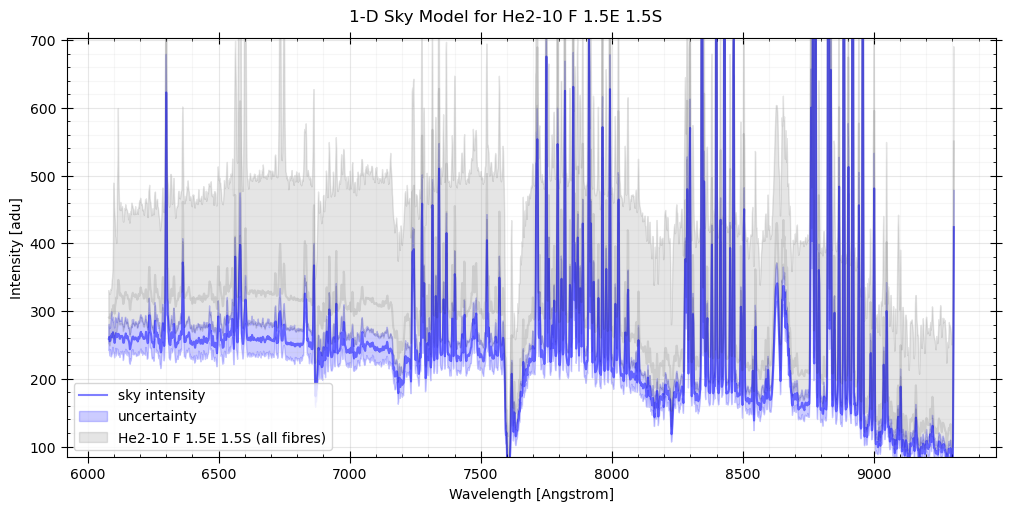

In [11]:
show_if(test_alternative_methods, sky_model.qc_plots.get('sky_model'))


## Alternative procedures

By default, `SkyFromObject` looks for a list of sky fibres in `rss0.info` and
estimates them if missing. You can also pick different `BackgroundEstimator`
strategies or choose which fibres are used.


In [12]:
help(sky.BackgroundEstimator)

Help on class BackgroundEstimator in module pykoala.utils.signal:

class BackgroundEstimator(builtins.object)
 |  Class for estimating background and its dispersion using different statistical methods.
 |
 |  Static methods defined here:
 |
 |  biweight(rss_intensity)
 |      Estimate the background and dispersion using the biweight method.
 |
 |      Parameters
 |      ----------
 |      rss_intensity : np.ndarray
 |          Input array (n_fibres x n_wavelength).
 |
 |      Returns
 |      -------
 |      background : np.ndarray
 |          Computed background (location) of the data.
 |      background_sigma : np.ndarray
 |          Dispersion (scale) of the data.
 |
 |  mad(rss_intensity)
 |      Estimate the background from the median and the dispersion from
 |      the Median Absolute Deviation (MAD) along the given axis.
 |
 |      Parameters
 |      ----------
 |      rss_intensity : np.ndarray
 |          Input array (n_fibres x n_wavelength).
 |
 |      Returns
 |      -------

In [13]:
# Example: robust background using all fibres with a kappa-sigma source mask
if test_alternative_methods:
    sky_sigma_clip = sky.SkyFromObject(
        rss0, bckgr_estimator='mad', sky_fibres='all',
        source_mask_kappa_sigma=3, qc_plots={'show': False}
    )


[pykoala.SkyModel] 2025/10/05 21:08|INFO> Creating SkyModel from input Data Container
[pykoala.SkyModel] 2025/10/05 21:08|INFO> Selecting all fibres
[pykoala.SkyModel] 2025/10/05 21:08|INFO> Pre-estimating background using all data
[pykoala.SkyModel] 2025/10/05 21:08|INFO> Applying sigma-clipping mask (n-sigma=3)
[pykoala.SkyModel] 2025/10/05 21:08|INFO> Applying the mad estimator to 986 sky fibres


In [14]:
show_if(test_alternative_methods, sky_sigma_clip.qc_plots.get('sky_fibres'))


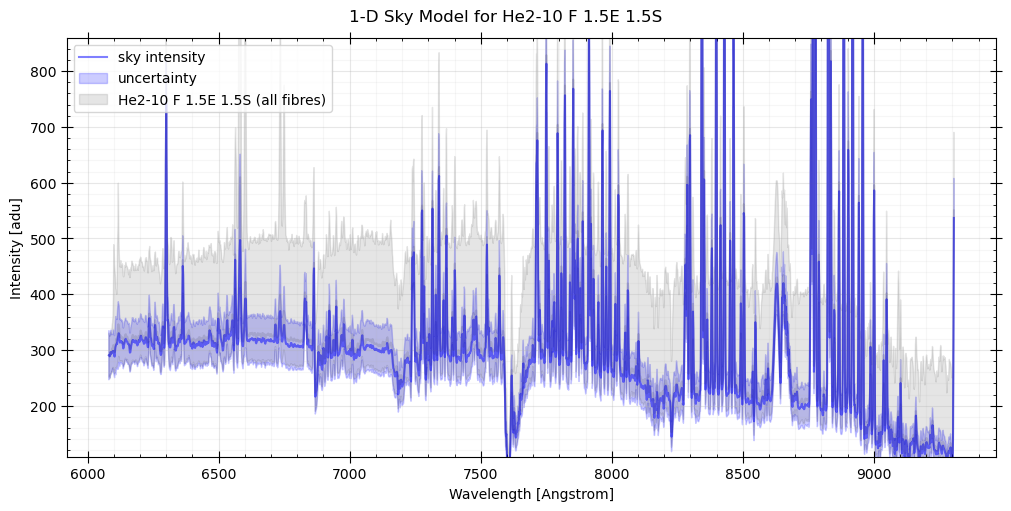

In [15]:
show_if(test_alternative_methods, sky_sigma_clip.qc_plots.get('sky_model'))


In [16]:
# Example: use 'mode' estimator across all fibres
if test_alternative_methods:
    sky_mode = sky.SkyFromObject(
        rss0, bckgr_estimator='mode', sky_fibres='all', qc_plots={'show': False}
    )


[pykoala.SkyModel] 2025/10/05 21:08|INFO> Creating SkyModel from input Data Container
[pykoala.SkyModel] 2025/10/05 21:08|INFO> Selecting all fibres
[pykoala.SkyModel] 2025/10/05 21:08|INFO> Applying the mode estimator to 986 sky fibres


In [17]:
show_if(test_alternative_methods, sky_mode.qc_plots.get('sky_fibres'))


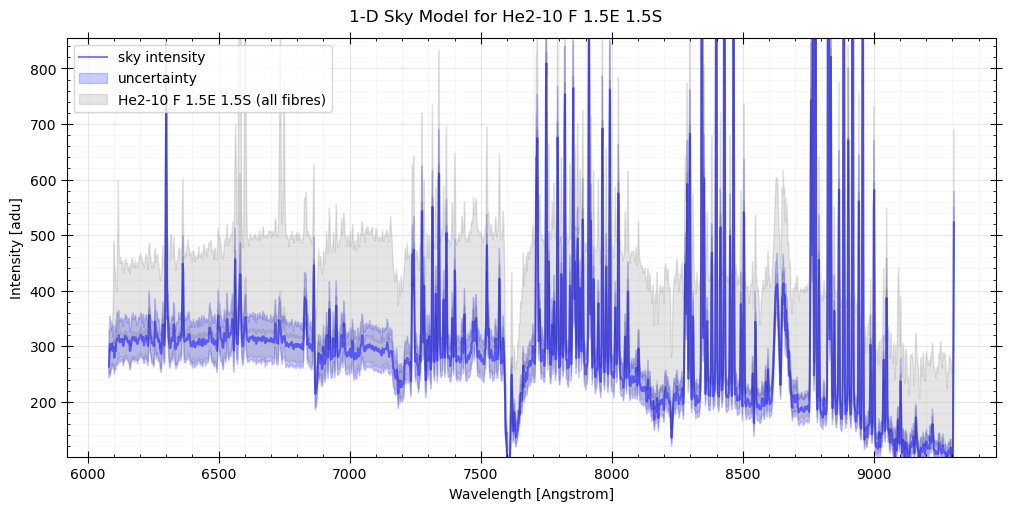

In [18]:
show_if(test_alternative_methods, sky_mode.qc_plots.get('sky_model'))


## Single-wavelength diagnostic

This plot helps visualise which fibres are considered sky-dominated at a given
wavelength.


In [19]:
help(sky_model.plot_individual_wavelength)

Help on method plot_individual_wavelength in module pykoala.corrections.sky:

plot_individual_wavelength(wavelength) method of pykoala.corrections.sky.SkyFromObject instance
    Diagnostic plot of fibre intensities at a single wavelength.

    The figure compares raw and normalised intensities versus the mean
    fibre flux, highlighting the fibres currently flagged as sky.

    Parameters
    ----------
    wavelength : float
        Wavelength at which to extract the per-fibre intensities.

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure with two panels: raw intensity and normalised intensity.



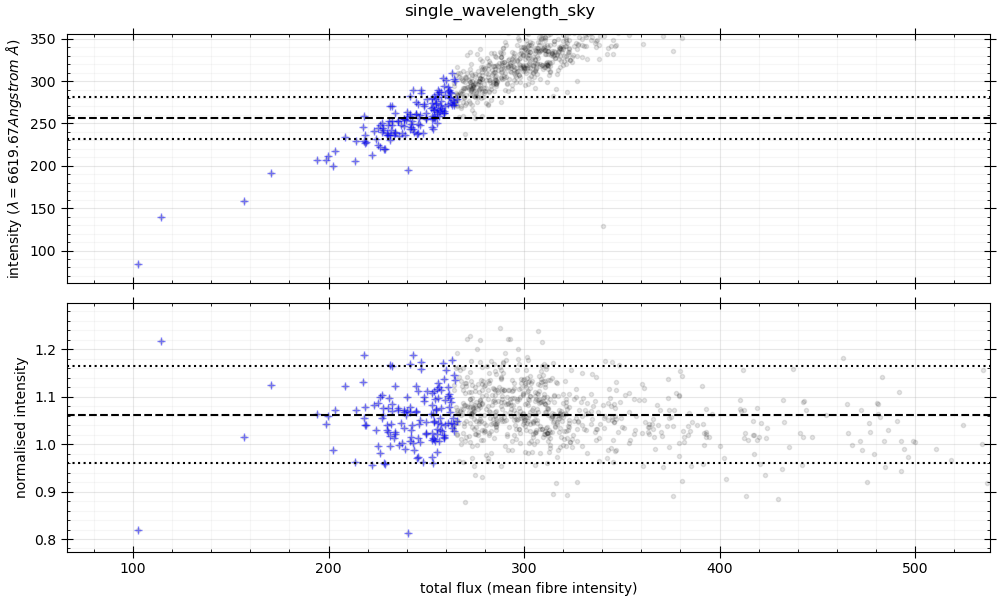

In [20]:
# Choose a wavelength (Å) to inspect
wl = 6620
fig = sky_model.plot_individual_wavelength(wl)
# fig.show()  # uncomment to force display in some frontends


# 3. PCA-based residual sky subtraction

In [21]:
help(sky.SkyModel.subtract_pca)

Help on function subtract_pca in module pykoala.corrections.sky:

subtract_pca(
    self,
    data,
    *,
    variance=None,
    axis=-1,
    mask=None,
    training_spectra_idx=None,
    use_line_atlas=True,
    eline_weight_threshold=0.25,
    standardize=False,
    n_components='auto',
    explained_variance_thresh=0.9,
    max_components=None,
    return_model=False
)
    Subtract residual sky using PCA components learned from the exposure.

    The method first removes the provided global sky model, then learns PCA
    components from sky-dominated spectra restricted to sky-line wavelength
    regions. Each spectrum is projected onto these components and the fitted
    residual sky is subtracted. If input variances are provided, the method
    performs weighted projections and **propagates the PCA model uncertainty**
    into the output variance.

    Parameters
    ----------
    data : ndarray
        Input cube or RSS with a known spectral axis (see `axis`).
        Shape can 

[pykoala.correction.SkyCorrection] 2025/10/05 21:09|INFO> Applying sky subtraction


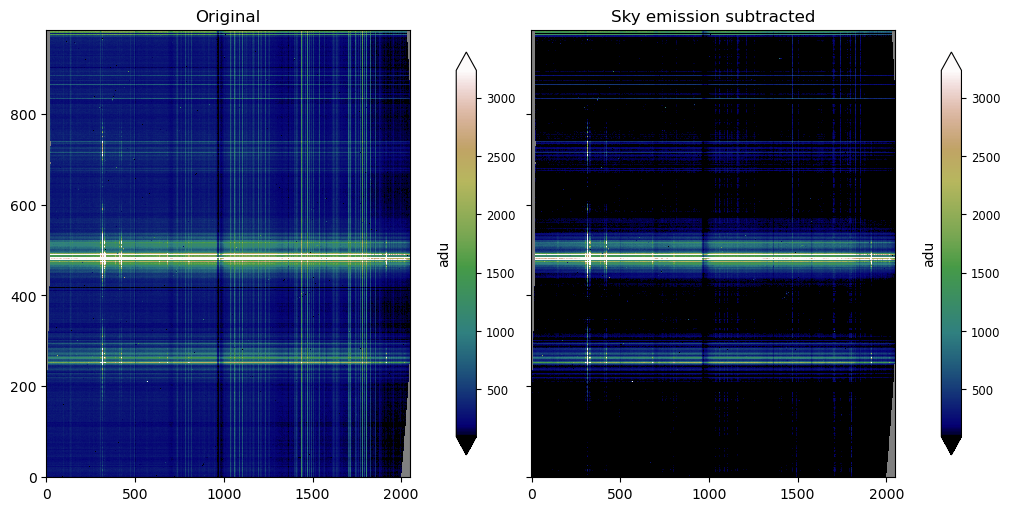

In [ ]:
# Apply PCA-based subtraction using the model above
corr = sky.SkySubsCorrection(sky_model)

dc_corr, fig_pca, pca_model = corr.apply(
    rss0, plot=True, pca=True,
    pca_kwargs=dict(
        use_line_atlas=True,
        eline_weight_threshold=0.25,
        explained_variance_thresh=0.99,
        max_components=20,
        standardize=False
    )
)
fig_pca


### Inspect the PCA model

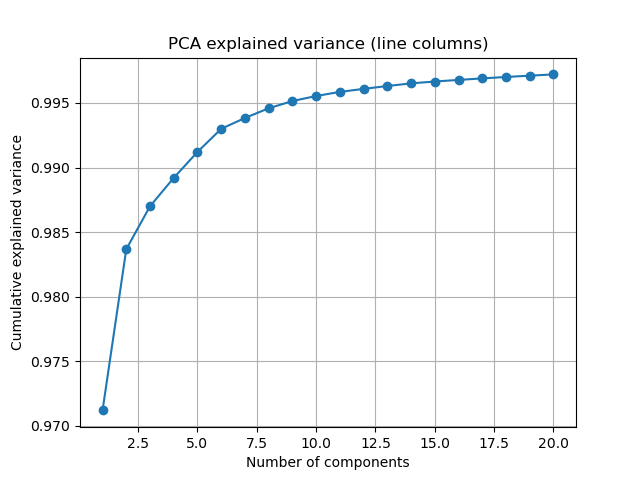

In [31]:
# Plot cumulative explained variance
evr = np.asarray(pca_model['explained_variance_ratio'])
cum = np.cumsum(evr)
plt.figure()
plt.plot(np.arange(1, evr.size+1), cum, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA explained variance (line columns)')
plt.grid(True)
plt.show()


### Compare standard subtraction vs PCA

[pykoala.correction.SkyCorrection] 2025/10/05 21:10|INFO> Applying sky subtraction


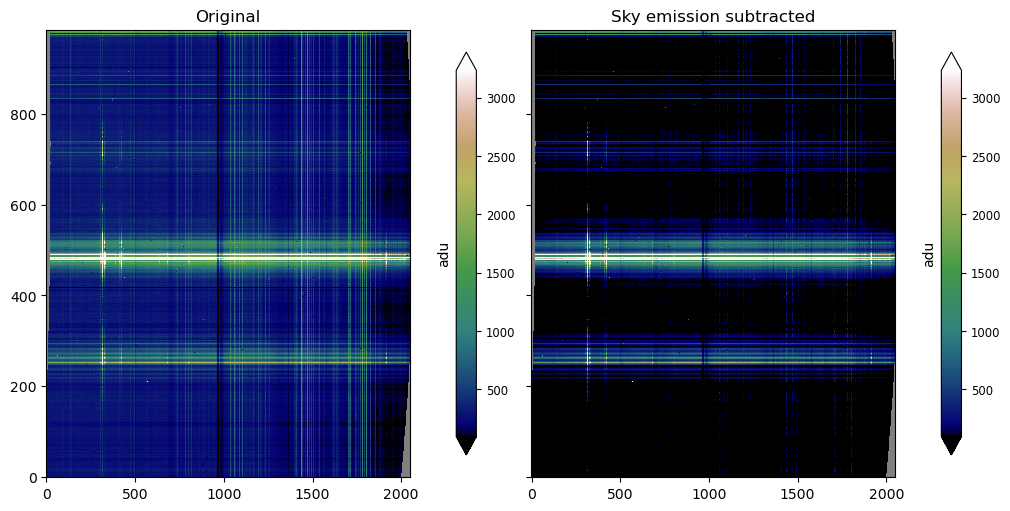

In [32]:
# Standard (non-PCA) subtraction for comparison
corr_simple = sky.SkySubsCorrection(sky_model)
dc_simple, fig_simple = corr_simple.apply(rss0, plot=True, pca=False)

fig_simple


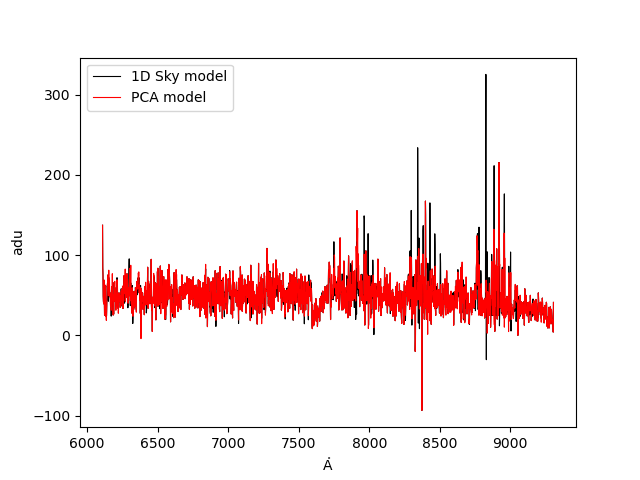

In [34]:
fibre = 400

plt.figure()
plt.plot(dc_simple.wavelength, dc_simple.intensity[fibre], label="1D Sky model", lw=0.8, c="k")
plt.plot(dc_corr.wavelength, dc_corr.intensity[fibre], label="PCA model", lw=0.8, c="r")
plt.legend()


# 4. (Optional) Save / load models

A convenience serialisation function may be added in the future. For now, we
recommend storing the 1-D arrays you need (e.g. `wavelength`, `intensity`,
`variance`) with `numpy.savez` or similar, and re-creating a `SkyModel`
instance manually when loading.


In [26]:
# Example sketch (adjust to your needs):
# np.savez('sky_model_koala.npz',
#          wavelength=sky_model.wavelength,
#          intensity=sky_model.intensity,
#          variance=sky_model.variance)
#
# dat = np.load('sky_model_koala.npz')
# sky_loaded = sky.SkyModel(wavelength=dat['wavelength'],
#                           intensity=dat['intensity'],
#                           variance=dat['variance'])


# 5. Save / load `SkyModel` to FITS (QTable)

The `SkyModel` class provides convenience methods to persist **1‑D** models
using an Astropy `QTable` under the hood:

- `SkyModel.to_fits(path, overwrite=True)`
- `SkyModel.from_fits(path)`

Below we save the model we built earlier and load it back, then perform a quick
sanity check.


In [27]:
# Save the current model as a FITS table using QTable
out_fits = "sky_model_koala.fits"
sky_model.to_fits(out_fits, overwrite=True)
print(f"Saved SkyModel to: {out_fits}")


Saved SkyModel to: sky_model_koala.fits


In [28]:
# Load the model back from disk
sky_model_loaded = sky.SkyModel.from_fits(out_fits, verbose=False)
print("Loaded SkyModel. Columns present:",
      "wavelength" if hasattr(sky_model_loaded, "wavelength") else "-",
      "intensity"  if hasattr(sky_model_loaded, "intensity")  else "-",
      "variance"   if hasattr(sky_model_loaded, "variance")   else "-",
      "continuum"  if hasattr(sky_model_loaded, "continuum")  else "-")

# Quick value and unit checks (best-effort, will not fail the cell)
def value_array(x):
    try:
        return x.to_value(x.unit)
    except Exception:
        try:
            return x.value
        except Exception:
            return np.asarray(x)

ok_len = (len(sky_model_loaded.wavelength) == len(sky_model.wavelength))
ok_val = np.allclose(value_array(sky_model_loaded.intensity),
                     value_array(sky_model.intensity),
                     rtol=1e-8, atol=1e-12, equal_nan=True)

print(f"Same length: {ok_len}; same intensity values: {ok_val}")


Loaded SkyModel. Columns present: wavelength intensity variance continuum
Same length: True; same intensity values: True


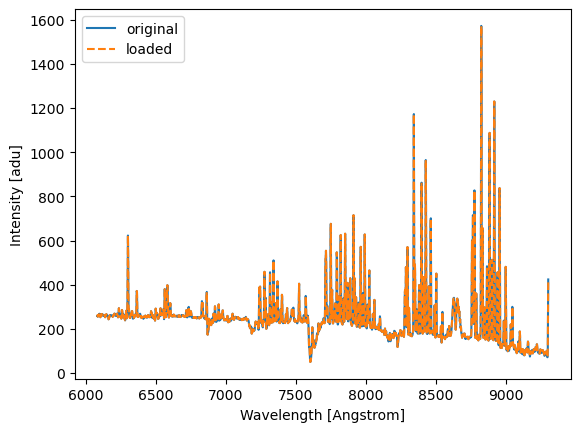

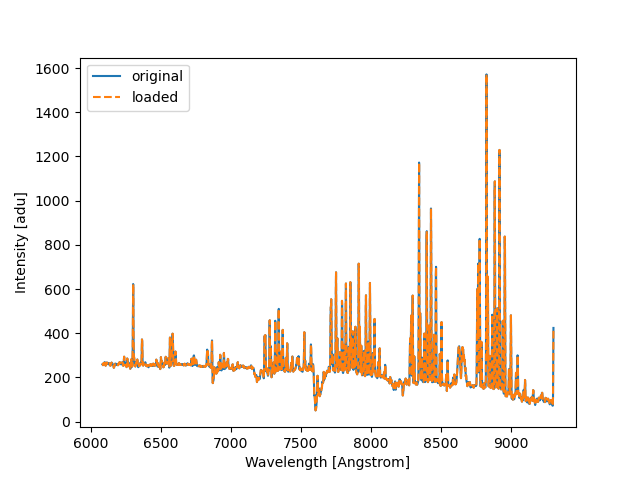

In [29]:
# Optional overlay plot to visually confirm
fig, ax = plt.subplots()
ax.plot(sky_model.wavelength, sky_model.intensity, label="original")
ax.plot(sky_model_loaded.wavelength, sky_model_loaded.intensity, ls="--", label="loaded")
ax.set_xlabel(f"Wavelength [{getattr(sky_model.wavelength, 'unit', '')}]")
ax.set_ylabel(f"Intensity [{getattr(sky_model.intensity, 'unit', '')}]")
ax.legend()
fig
